In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
from datetime import datetime
import sys,os
from glob import glob
import imageio


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Aug 12 17:36:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
#Get the data
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2023-08-12 17:36:43--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  48.6MB/s    in 10s     

2023-08-12 17:36:53 (42.8 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [6]:
!ls

Food-5K.zip  sample_data


In [7]:
!unzip -qq -o Food-5K.zip

In [8]:
!ls Food-5K

evaluation  training  validation


In [9]:
!ls Food-5K/training

0_0.jpg     0_1387.jpg	0_422.jpg  0_809.jpg   1_1195.jpg  1_230.jpg  1_617.jpg
0_1000.jpg  0_1388.jpg	0_423.jpg  0_80.jpg    1_1196.jpg  1_231.jpg  1_618.jpg
0_1001.jpg  0_1389.jpg	0_424.jpg  0_810.jpg   1_1197.jpg  1_232.jpg  1_619.jpg
0_1002.jpg  0_138.jpg	0_425.jpg  0_811.jpg   1_1198.jpg  1_233.jpg  1_61.jpg
0_1003.jpg  0_1390.jpg	0_426.jpg  0_812.jpg   1_1199.jpg  1_234.jpg  1_620.jpg
0_1004.jpg  0_1391.jpg	0_427.jpg  0_813.jpg   1_119.jpg   1_235.jpg  1_621.jpg
0_1005.jpg  0_1392.jpg	0_428.jpg  0_814.jpg   1_11.jpg    1_236.jpg  1_622.jpg
0_1006.jpg  0_1393.jpg	0_429.jpg  0_815.jpg   1_1200.jpg  1_237.jpg  1_623.jpg
0_1007.jpg  0_1394.jpg	0_42.jpg   0_816.jpg   1_1201.jpg  1_238.jpg  1_624.jpg
0_1008.jpg  0_1395.jpg	0_430.jpg  0_817.jpg   1_1202.jpg  1_239.jpg  1_625.jpg
0_1009.jpg  0_1396.jpg	0_431.jpg  0_818.jpg   1_1203.jpg  1_23.jpg   1_626.jpg
0_100.jpg   0_1397.jpg	0_432.jpg  0_819.jpg   1_1204.jpg  1_240.jpg  1_627.jpg
0_1010.jpg  0_1398.jpg	0_433.jpg  0_81.jpg    1_1205.j

In [10]:
!mv Food-5K/* .

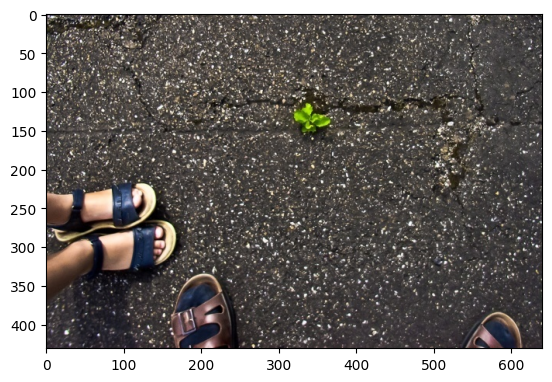

In [11]:
plt.imshow(imageio.v2.imread("training/0_1096.jpg"))
plt.show()

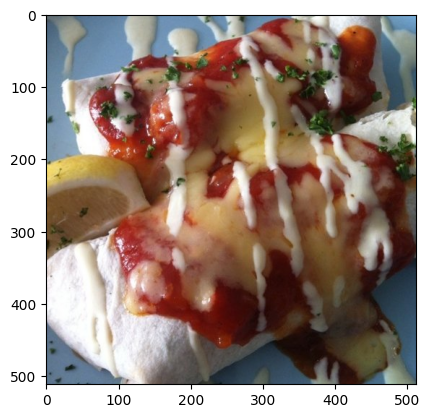

In [12]:
plt.imshow(imageio.v2.imread("training/1_337.jpg"))
plt.show()

In [13]:
#Creating the Data directory inorder to use imageFolder functionality

!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/test/nonfood
!mkdir data/train/food
!mkdir data/test/food

In [14]:
!mv training/0*.jpg data/train/nonfood
!mv validation/0*.jpg data/test/nonfood
!mv training/1*.jpg data/train/food
!mv validation/1*.jpg data/test/food

In [15]:
#Data Augmentation

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.CenterCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [16]:
#Dataset

train_dataset = datasets.ImageFolder("data/train",transform = train_transform)
test_dataset = datasets.ImageFolder("data/test",transform = test_transform)

In [17]:
#Dataloader
batch_size = 128
train_data = torch.utils.data.DataLoader(dataset = train_dataset,batch_size = batch_size,shuffle = True )
test_data = torch.utils.data.DataLoader(dataset = test_dataset,batch_size = batch_size,shuffle = False )

In [18]:
#model VGG

model = models.vgg16(pretrained= True)
for i in model.parameters():
  i.requires_grad = False



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 155MB/s]


In [19]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [21]:
n_features = model.classifier[0].in_features
n_features

25088

In [22]:
model.classifier = nn.Linear(n_features,2)
model.classifier

Linear(in_features=25088, out_features=2, bias=True)

In [23]:
#optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [25]:
model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
#training

epochs = 10
train_loss = np.zeros(epochs)
test_loss= np.zeros(epochs)

for i in range(epochs):


  t_0 = datetime.now()
  loss_train_list = []
  for inputs,targets in train_data:

    # targets = targets.view(-1,1).float()

    inputs,targets = inputs.to(device), targets.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss_train = criterion(outputs,targets)

    loss_train.backward()

    optimizer.step()

    loss_train_list.append(loss_train.item())


  train_loss_mean = np.mean(loss_train_list)
  train_loss[i] = train_loss_mean

  loss_test_list = []

  for inputs,targets in test_data:
    # targets = targets.view(-1,1).float()

    inputs,targets = inputs.to(device), targets.to(device)

    outputs = model(inputs)

    loss_test = criterion(outputs,targets)



    loss_test_list.append(loss_test.item())

  test_loss_mean = np.mean(loss_test_list)
  test_loss[i] = test_loss_mean

  dt = datetime.now() - t_0
  print(f"epoch -- {i+1}/{epochs}, training loss -- {train_loss_mean}, test loss -- {test_loss_mean}, Duration -- {dt}")











epoch -- 1/10, training loss -- 0.18465430815316117, test loss -- 0.10652189234315301, Duration -- 0:00:48.318313
epoch -- 2/10, training loss -- 0.052386379107095614, test loss -- 0.05691817490151152, Duration -- 0:00:46.035998
epoch -- 3/10, training loss -- 0.036874277867658144, test loss -- 0.0483713707071729, Duration -- 0:00:46.727292
epoch -- 4/10, training loss -- 0.01900703822275318, test loss -- 0.05128475261153653, Duration -- 0:00:48.018586
epoch -- 5/10, training loss -- 0.019492137951601762, test loss -- 0.050545979756861925, Duration -- 0:00:47.383651
epoch -- 6/10, training loss -- 0.010634706188284326, test loss -- 0.05521351893548854, Duration -- 0:00:47.938572
epoch -- 7/10, training loss -- 0.007825522453155523, test loss -- 0.058524952652078355, Duration -- 0:00:47.685259
epoch -- 8/10, training loss -- 0.007261304505846056, test loss -- 0.0451089745038189, Duration -- 0:00:48.284987
epoch -- 9/10, training loss -- 0.013962797010511471, test loss -- 0.0400587242183

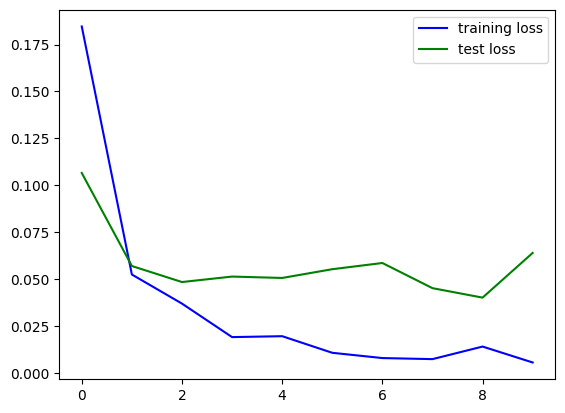

In [28]:
#plotting losses
plt.plot(train_loss,label = "training loss", color = "blue")
plt.plot(test_loss,label = "test loss", color = "green")
plt.legend()
plt.show()

In [29]:
#Accuracy

n_correct = 0
n_total= 0

for inputs, targets in train_data:

  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  _, predictions = torch.max(outputs,1)

  n_correct += (predictions==targets).sum()
  n_total += len(targets)

Accuracy_train = n_correct/n_total

for inputs, targets in test_data:

  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  _, predictions = torch.max(outputs,1)

  n_correct += (predictions==targets).sum()
  n_total += len(targets)

Accuracy_test = n_correct/n_total


print("training accuracy -- ", Accuracy_train)
print("test accuracy -- ", Accuracy_test)




training accuracy --  tensor(0.9980, device='cuda:0')
test accuracy --  tensor(0.9943, device='cuda:0')
